In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from keras.layers import Dense, Dropout, Activation, LSTM, Convolution1D, MaxPooling1D, Flatten
from keras.models import Sequential
import matplotlib.pyplot as plt
%matplotlib inline

try: 
    import torchbearer
except:
    !pip install torchbearer
    import torchbearer
    
from torchbearer import Trial

Using TensorFlow backend.


In [2]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchbearer
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision.datasets import MNIST
from torchbearer import Trial
import torchvision.transforms as transforms

In [3]:
## Data preparation
%ls

 驱动器 D 中的卷没有标签。
 卷的序列号是 14DF-F7F4

 D:\git\Stock-Market-Price-Prediction-master 的目录

2019/07/08  16:27    <DIR>          .
2019/07/08  16:27    <DIR>          ..
2019/07/03  15:28    <DIR>          .ipynb_checkpoints
2019/06/22  15:43           363,722 ^DJI.csv
2019/06/26  00:18           103,280 ^GSPC.csv
2019/07/05  21:11           381,476 5_1_CNN-Copy1.ipynb
2019/06/24  16:48           335,219 Archive.zip
2019/06/14  11:01               658 CBOE yearly 04-18.csv
2019/06/14  11:51           189,414 EUR_GBP 05-16.csv
2019/06/14  11:47           189,007 EUR_JPY 05-16.csv
2019/06/14  11:44           189,396 EUR_USD 05-16.csv
2019/06/14  11:49           189,370 GBP_JPY 05-16.csv
2019/06/14  11:54           189,425 GBP_USD 05-16.csv
2019/07/03  14:29    <DIR>          MNIST
2018/01/07  10:01             1,031 README.md
2019/06/14  11:31           206,054 SP500 05-16.csv
2019/06/26  14:00           125,642 stock_conv1d.ipynb
2019/06/26  13:44           135,759 stock_conv1d-Copy1.ipynb
2019

In [4]:
data= pd.read_csv('^DJI.csv')
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
4279,2017-01-05,19924.560547,19948.599609,19811.119141,19899.289063,19899.289063,269920000
4280,2017-01-06,19906.960938,19999.630859,19834.080078,19963.800781,19963.800781,277700000
4281,2017-01-09,19931.410156,19943.779297,19887.380859,19887.380859,19887.380859,287060000
4282,2017-01-10,19876.349609,19957.119141,19836.029297,19855.529297,19855.529297,299410000
4283,2017-01-11,19887.380859,19973.419922,19833.160156,19954.279297,19954.279297,336150000


In [5]:
data= data.dropna(axis=0)#drop rows which may contain missing values
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
4279,2017-01-05,19924.560547,19948.599609,19811.119141,19899.289063,19899.289063,269920000
4280,2017-01-06,19906.960938,19999.630859,19834.080078,19963.800781,19963.800781,277700000
4281,2017-01-09,19931.410156,19943.779297,19887.380859,19887.380859,19887.380859,287060000
4282,2017-01-10,19876.349609,19957.119141,19836.029297,19855.529297,19855.529297,299410000
4283,2017-01-11,19887.380859,19973.419922,19833.160156,19954.279297,19954.279297,336150000


In [6]:
data= data.values[:, 1:5]
print (data.shape)

(4284, 4)


In [7]:
print (data[:6, :])

[[11501.849609 11522.009766 11305.69043 11357.509766]
 [11349.75 11350.05957 10986.450195 10997.929688]
 [10989.370117 11215.099609 10938.669922 11122.650391]
 [11113.370117 11313.450195 11098.450195 11253.259766]
 [11247.05957 11528.139648 11239.919922 11522.55957]
 [11532.480469 11638.280273 11532.480469 11572.200195]]


In [8]:
y= data[1:, 3] #the close price
print (y.shape)
X= data[:4283,:]
print (X.shape)

(4283,)
(4283, 4)


In [9]:
y= (y- min(y))/(max(y)- min(y)) #??? normalsation
print (y[4270:])
print (y[:7])

[0.9958489671060151 0.9969608353545725 0.9977970638423223
 0.9895037255460575 0.9884685127944293 0.9842101331451283
 0.9930844240922265 0.9975826611512648 0.9943898946924046
 0.9991943173236132 0.9935030473634489 0.9911309455181354
 0.9984852177269742]
[0.3314732377562158 0.34076164281889654 0.3504885987356185
 0.3705443360966607 0.37424125426240135 0.36968941651198045
 0.3726698167615406]


In [10]:
X= (X- np.min(X,axis=0))/(np.max(X, axis=0)-np.min(X,axis=0))
print (X.shape)
print (X[:3, :])

(4283, 4)
[[0.36915916133693344 0.36210626788689226 0.3589471777635444
  0.35825247597887355]
 [0.35782701622684665 0.34916797410603573 0.335250623396864
  0.3314732377562158]
 [0.33097699895354726 0.3390129893215408 0.33170399075890933
  0.34076164281889654]]


In [11]:
## Sequence data preparation
"""
Rowling the window size = 100 days
This example is in sample forcasting
what is different of in sample and out of sample forecasting: 

https://stats.stackexchange.com/questions/260899/what-is-difference-between-in-sample-and-out-of-sample-forecasts
"""

'\nRowling the window size = 100 days\nThis example is in sample forcasting\nwhat is different of in sample and out of sample forecasting: \n\nhttps://stats.stackexchange.com/questions/260899/what-is-difference-between-in-sample-and-out-of-sample-forecasts\n'

In [12]:
time_steps= 100 #1 to 100 days ahead
X_new= np.zeros((X.shape[0] - time_steps +1, 100, X.shape[1]))
y_new= np.zeros((y.shape[0] -time_steps +1,))
for ix in range(X_new.shape[0]):
    for jx in range(time_steps):
        X_new[ix, jx, :]= X[ix +jx, :]
    y_new[ix]= y[ix + time_steps -1]
print (X_new.shape, y_new.shape)

(4184, 100, 4) (4184,)


In [13]:
## split into train and test sets

In [14]:
split = int(0.8*data.shape[0])
X_train = X_new[:split]
X_test = X_new[split:]

y_train = y_new[:split]
y_test = y_new[split:]

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(3427, 100, 4) (3427,)
(757, 100, 4) (757,)


In [15]:
## Model fitting

In [ ]:
model = Sequential()
model.add(Convolution1D(64, 3, input_shape= (100,4), border_mode='same'))
model.add(MaxPooling1D(pool_length=2))
model.add(Convolution1D(32, 3, border_mode='same'))
model.add(MaxPooling1D(pool_length=2))
model.add(Flatten())
model.add(Dense(output_dim=1))
model.add(Activation('linear'))

model.summary()

In [16]:
from torchsummary import summary
    
class Net(nn.Module):  
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 64, kernel_size = (3, 4), padding=0)
        self.conv2 = nn.Conv2d(64, 32, kernel_size = (3, 1), padding=0)
        self.fc1 = nn.Linear(3008 , 1)
        
        
    def forward(self,x):
        out = self.conv1(x)
#         out = F.relu(out)
        out = F.max_pool2d(out, kernel_size = (2, 1), stride=(1, 1))
        out = self.conv2(out)
#         out = F.relu(out)
        out = F.max_pool2d(out, kernel_size = (2, 1), stride=(1, 1))
        out = out.view(out.shape[0], -1)
        out = self.fc1(out)
#         out = F.relu(out)
        return out

    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)


# summary(your_model, input_size=(channels, H, W))
summary(model,(1, 100, 4))
print(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 64, 98, 1]             832
            Conv2d-2            [-1, 32, 95, 1]           6,176
            Linear-3                    [-1, 1]           3,009
Total params: 10,017
Trainable params: 10,017
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.04
Estimated Total Size (MB): 0.11
----------------------------------------------------------------
Net(
  (conv1): Conv2d(1, 64, kernel_size=(3, 4), stride=(1, 1))
  (conv2): Conv2d(64, 32, kernel_size=(3, 1), stride=(1, 1))
  (fc1): Linear(in_features=3008, out_features=1, bias=True)
)


In [17]:
# model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [18]:
print(X_train.shape)
print(y_train.shape)
# X_train = np.expand_dims(X_train, axis=0)
# y_train = np.expand_dims(y_train, axis=0)
# print(X_train.shape, y_train.shape)

(3427, 100, 4)
(3427,)


In [19]:
trainData = torch.from_numpy(X_train)
testData = torch.from_numpy(y_train)
validateData = torch.from_numpy(X_test)
# # create data loaders
# trainloader = DataLoader(trainData, batch_size=128, shuffle=True)
# testloader = DataLoader(testData, batch_size=128, shuffle=True)

In [20]:
trainData = trainData.view(3427,-1,100,4)
testData = testData.view(3427,-1)

validateData = validateData.view(validateData.shape[0],-1,100,4)
print(trainData.shape,testData.shape,validateData.shape)

torch.Size([3427, 1, 100, 4]) torch.Size([3427, 1]) torch.Size([757, 1, 100, 4])


In [21]:
train = TensorDataset(trainData, testData)
# print(train[0])
tr, te = train[0]
print(tr.shape, te.shape)

torch.Size([1, 100, 4]) torch.Size([1])


In [22]:
trainloader = DataLoader(train, batch_size=256, shuffle=True)

In [23]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([256, 1, 100, 4])
torch.Size([256, 1])


In [24]:
from torch import optim
# define the loss function and the optimiser
loss_function = nn.MSELoss()
optimiser = optim.Adam(model.parameters())

In [25]:
# # flatten 28*28 images to a 784 vector for each image
# transform = transforms.Compose([
#     transforms.ToTensor(),  # convert to tensor
#     transforms.Lambda(lambda x: x.view(-1))  # flatten into vector
# ])

# trainset = MNIST(".", train=True, download=True, transform=transform)
# a,_ = trainset[0]
# a.shape

In [26]:
# model.fit(X_train, y_train, batch_size=256, nb_epoch=50,  verbose=2)

# pytorch method for training
trial = Trial(model, optimiser, loss_function).to(device)
trial.with_generators(trainloader)
trial.run(epochs=10)
# results = trial.evaluate(data_key=torchbearer.TEST_DATA)
# print(results)

[((14, None), {}),
 ((14, None), {}),
 ((14, None), {}),
 ((14, None), {}),
 ((14, None), {}),
 ((14, None), {}),
 ((14, None), {}),
 ((14, None), {}),
 ((14, None), {}),
 ((14, None), {})]

In [27]:
#save the trained model weights
torch.save(model.state_dict(), "./1d_conv.weights")

In [28]:
# print (score)
validateData.float().shape

torch.Size([757, 1, 100, 4])

In [29]:
# validateData.float()[0].view(1,1,100,4).shape

In [30]:
y_pred= model(validateData.float().to(device))
y_pred.shape

torch.Size([757, 1])

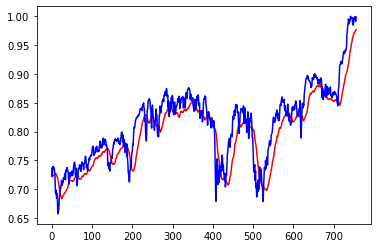

In [31]:
plt.plot(y_pred.cpu().detach().numpy(), 'r-')
plt.plot(y_test, 'b-')
plt.show()

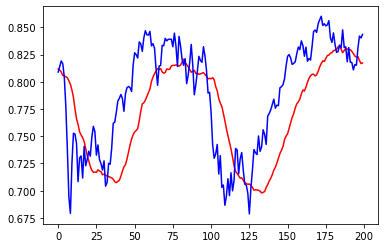

In [32]:
plt.plot(y_pred.cpu().detach().numpy()[400:600], 'r-')
plt.plot(y_test[400:600], 'b-')
plt.show()

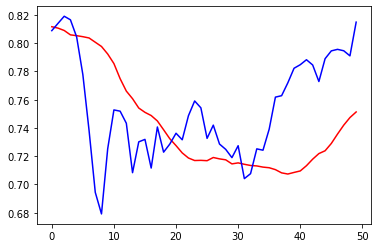

In [33]:
plt.plot(y_pred.cpu().detach().numpy()[400:450], 'r-')
plt.plot(y_test[400:450], 'b-')
plt.show()

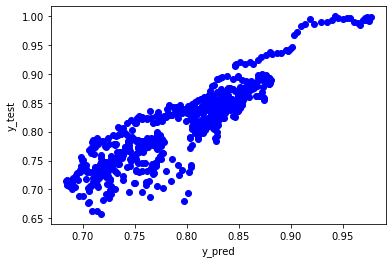

In [34]:
plt.plot (y_pred.cpu().detach().numpy(), y_test, 'bo')
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()